# Set Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, Dropout, Input, Activation, Reshape, GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from sklearn.preprocessing import OneHotEncoder
import os ,random
import shutil
import sys
import matplotlib.pyplot as plt
import h5py
import pickle
from keras.preprocessing.image import load_img, img_to_array, array_to_img


In [4]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [5]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [6]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5
learning_rate =1e-4

# Loading Dataset

## LC25000 Dataset

In [7]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [8]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

<function matplotlib.pyplot.show>

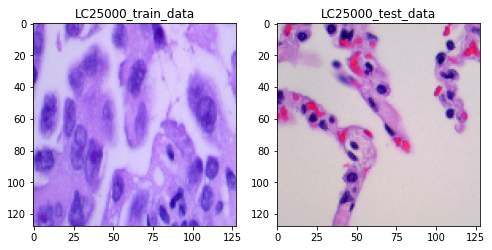

In [9]:
# random show images
plt.subplots(1,2,figsize=(8,8))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.title("LC25000_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data")
plt.imshow(img2)
plt.show

In [10]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

In [11]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)
LC25000_test_data = np.array(LC25000_test_data, dtype=np.float32)

In [12]:
print("The shape of LC25000_train_data: ", LC25000_train_data.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)
print("The shape of LC25000_test_data: ", LC25000_test_data.shape)
print("The shape of LC25000_test_labels: " ,LC25000_test_labels.shape)

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


## TCGA Dataset

In [13]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train), "rb") as f:
    TCGA_train = pickle.load(f)
with open(os.path.abspath(Target_dir_test), "rb") as f:
    TCGA_test = pickle.load(f)

In [14]:
TCGA_train_data = TCGA_train['train']
TCGA_train_labels = TCGA_train['train_label']
TCGA_test_data = TCGA_test['test']
TCGA_test_labels = TCGA_test['test_label']

<function matplotlib.pyplot.show>

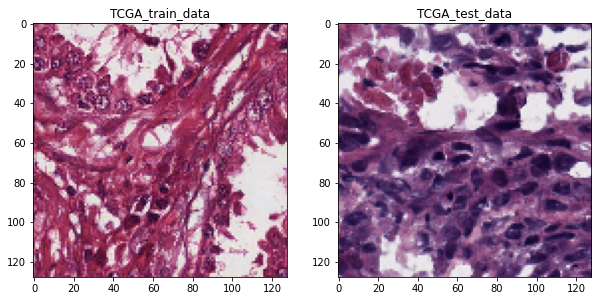

In [15]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

In [16]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)

In [17]:
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [18]:
print("The shape of TCGA_train_data: ", TCGA_train_data.shape)
print("The shape of TCGA_train_labels: ", TCGA_train_labels.shape)
print("The shape of TCGA_test_data: ", TCGA_test_data.shape)
print("The shape of TCGA_test_labels: " , TCGA_test_labels.shape)

The shape of TCGA_train_data:  (6400, 128, 128, 3)
The shape of TCGA_train_labels:  (6400,)
The shape of TCGA_test_data:  (6400, 128, 128, 3)
The shape of TCGA_test_labels:  (6400,)


# Domain Adaptation

## Build Model

### Feature Extractor - VGG16

In [19]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

In [20]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [21]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))
TCGA_test_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_test_data)))


print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data (source) shape: (6400, 128, 128, 3)
TCGA_train_data (target) shape: (6400, 128, 128, 3)


### Prepare Datasets

In [22]:
source_dataset = tf.data.Dataset.from_tensor_slices((LC25000_train_data_ex, LC25000_train_lab)).shuffle(1000).batch(BATCH_SIZE*2)
da_dataset = tf.data.Dataset.from_tensor_slices((LC25000_train_data_ex, LC25000_train_lab, TCGA_train_data_ex, TCGA_train_lab)).shuffle(1000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((TCGA_test_data_ex, TCGA_test_lab)).shuffle(1000).batch(BATCH_SIZE*2) #Test Dataset over Target Domain
test_dataset2 = tf.data.Dataset.from_tensor_slices((TCGA_train_data_ex, TCGA_train_lab)).shuffle(1000).batch(BATCH_SIZE*2) #Test Dataset over Target (used for training)

### VGG16 Model

In [23]:
feature_extractor_vgg = load_vgg()

class DANN_vgg(Model):
    def __init__(self):
        super().__init__()
        
        #Feature Extractor
        self.vgg_load = feature_extractor_vgg
        
        #Label Predictor
        self.max_norm = 0.5
        self.dropout= 0.5
        self.label_predictor_layer0 = Dense(1024, activation="relu",
                                            kernel_constraint=MaxNorm(self.max_norm),
                                            bias_constraint=MaxNorm(self.max_norm))
        self.label_predictor_layer1 = Dropout(self.dropout)
        self.label_predictor_layer2 = Dense(1024, activation="relu",
                                            kernel_constraint=MaxNorm(self.max_norm),
                                            bias_constraint=MaxNorm(self.max_norm))
        self.label_predictor_layer3 = Dropout(self.dropout)
        self.label_predictor_layer4 = Dense(3, activation=None)
        
        #Domain Predictor
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = Dense(100, activation='relu')
        self.domain_predictor_layer2 = Dense(2, activation=None)
        
    def call(self, x, train=False, source_train=True, lamda=1.0):
        #Feature Extractor
        x = self.vgg_load(x)
        #print("x:", x)

        feature  = x
        
        #print("feature: ", feature)
        
        #Label Predictor
        if source_train is True:
            feature_slice = feature
            #print("feature_slice: ",feature_slice)
        else:
            feature_slice = tf.slice(feature, [0, 0], [feature.shape[0] // 2, -1])
            #print("feature_slice: ",feature_slice)
        
        lp_x = self.label_predictor_layer0(feature_slice)
        lp_x = self.label_predictor_layer1(lp_x)
        lp_x = self.label_predictor_layer2(lp_x)
        lp_x = self.label_predictor_layer3(lp_x)
        l_logits = self.label_predictor_layer4(lp_x)
        
        #Domain Predictor
        if source_train is True:
            #print("l_logits: " ,l_logits)
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(feature, lamda)    #GradientReversalLayer
            dp_x = self.domain_predictor_layer1(dp_x)
            d_logits = self.domain_predictor_layer2(dp_x)
            #print("l_logits-1: " ,l_logits)
            #print("d_logits-1", d_logits)
            return l_logits, d_logits


#model = DANN_resnet()

## Gradient Reversal Layer

In [24]:
@tf.custom_gradient
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad


class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_reverse(x, lamda)

## Define Loss and Optimizer

In [25]:
def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))


def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        #print("l_logits",l_logits)
        #print("labels",labels)
        return loss_func(l_logits, labels)
    else:
        #print("l_logits-2",l_logits)
        #print("labels-2",labels)
        #print("d_logits-2",d_logits)
        #print("domain-2",domain.shape)        
        return loss_func(l_logits, labels) + loss_func(d_logits, domain)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate= learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

model_optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
#model_optimizer = tf.optimizers.SGD(learning_rate=lr_schedule)


#model_optimizer = tf.optimizers.Adam(learning_rate=1e-4)
# model_optimizer = tf.optimizers.SGD(learning_rate=1e-4)

## Configuration of Training

In [26]:
domain_labels = np.vstack([np.tile([1., 0.], [BATCH_SIZE, 1]),
                           np.tile([0., 1.], [BATCH_SIZE, 1])])
domain_labels = domain_labels.astype('float32')

epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

source_acc = []  # Source Domain Accuracy while Source-only Training
da_acc = []      # Source Domain Accuracy while DA-training
test_acc = []    # Testing Dataset (Target Domain) Accuracy 
test2_acc = []   # Target Domain (used for Training) Accuracy

def reset_list():
    source_acc.clear() 
    da_acc.clear()
    test_acc.clear()
    test2_acc.clear()

In [27]:
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        
        model_loss = get_loss(output, labels)
        epoch_accuracy(output, labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        epoch_accuracy(output[0], labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    
    output = model(images, train=False, source_train=True)
    epoch_accuracy(output, labels)



def train(train_mode, epochs):
    
    if train_mode == 'source':
        dataset = source_dataset
        train_func = train_step_source
        acc_list = source_acc
    elif train_mode == 'domain-adaptation':
        dataset = da_dataset
        train_func = train_step_da
        acc_list = da_acc
    else:
        raise ValueError("Unknown training Mode")
    

    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-gamma * p, dtype=np.float32)) - 1
        lamda = lamda.astype('float32')

        
        for batch in dataset:
            train_func(*batch, lamda=lamda)
        
        print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        acc_list.append(epoch_accuracy.result())
        test()
        epoch_accuracy.reset_states()


def test():
    epoch_accuracy.reset_states()
    
    #Testing Dataset (Target Domain)

    for batch in test_dataset:
        test_step(*batch)
        
    print("Testing Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    test_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()
    
    #Target Domain (used for Training)
    for batch in test_dataset2:
        test_step(*batch)
    
    print("Target Domain Accuracy : {:.3%}".format(epoch_accuracy.result()))
    test2_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()

# Training

### domain-adaptation train : RMS=1e-6, gamma = 5

Training: Epoch 0 :	 Source Accuracy : 93.547%  |  Testing Accuracy : 49.078%  |  Target Domain Accuracy : 48.734%
Training: Epoch 1 :	 Source Accuracy : 74.375%  |  Testing Accuracy : 44.297%  |  Target Domain Accuracy : 44.563%
Training: Epoch 2 :	 Source Accuracy : 82.047%  |  Testing Accuracy : 11.359%  |  Target Domain Accuracy : 10.625%
Training: Epoch 3 :	 Source Accuracy : 81.656%  |  Testing Accuracy : 4.375%  |  Target Domain Accuracy : 4.391%
Training: Epoch 4 :	 Source Accuracy : 79.953%  |  Testing Accuracy : 50.000%  |  Target Domain Accuracy : 50.000%
Training: Epoch 5 :	 Source Accuracy : 78.703%  |  Testing Accuracy : 50.000%  |  Target Domain Accuracy : 49.984%
Training: Epoch 6 :	 Source Accuracy : 79.875%  |  Testing Accuracy : 49.984%  |  Target Domain Accuracy : 49.969%
Training: Epoch 7 :	 Source Accuracy : 82.812%  |  Testing Accuracy : 1.375%  |  Target Domain Accuracy : 1.469%
Training: Epoch 8 :	 Source Accuracy : 86.422%  |  Testing Accuracy : 21.125%  |  Ta

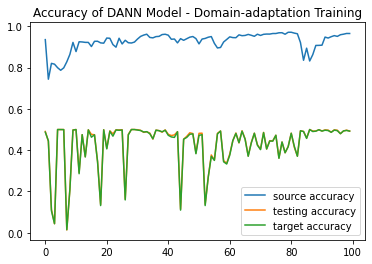

In [28]:
reset_list()

EPOCH= 100
model = DANN_vgg()
gamma = 5
learning_rate = 1e-6
model_optimizer = tf.optimizers.RMSprop(learning_rate=lr_schedule)
train('domain-adaptation', EPOCH)

#Plot Results
x_axis = [i for i in range(0, EPOCH)]

plt.title("Accuracy of DANN Model - Domain-adaptation Training")
plt.plot(x_axis, da_acc, label="source accuracy")
plt.plot(x_axis, test_acc, label="testing accuracy")
plt.plot(x_axis, test2_acc, label="target accuracy")
plt.legend()

In [29]:
import pandas as pd
lst1 = range(100)
lst2 = range(100)
lst3 = range(100)
train_data = pd.DataFrame(
    {"source accuracy": da_acc,
     "testing accuracy": test_acc,
     "target accuracy": test2_acc
    })
train_data.to_csv("./Model/DANN_Model/DANN_128/DANN_VGG_128_RMS_1e-6_g5.csv")

### source-only train: SGD=1e-6

Training: Epoch 0 :	 Source Accuracy : 83.562%  |  Testing Accuracy : 41.281%  |  Target Domain Accuracy : 40.734%
Training: Epoch 1 :	 Source Accuracy : 91.703%  |  Testing Accuracy : 43.531%  |  Target Domain Accuracy : 43.813%
Training: Epoch 2 :	 Source Accuracy : 93.422%  |  Testing Accuracy : 42.328%  |  Target Domain Accuracy : 42.953%
Training: Epoch 3 :	 Source Accuracy : 94.437%  |  Testing Accuracy : 41.828%  |  Target Domain Accuracy : 42.312%
Training: Epoch 4 :	 Source Accuracy : 95.141%  |  Testing Accuracy : 41.922%  |  Target Domain Accuracy : 42.203%
Training: Epoch 5 :	 Source Accuracy : 95.438%  |  Testing Accuracy : 41.984%  |  Target Domain Accuracy : 42.437%
Training: Epoch 6 :	 Source Accuracy : 95.828%  |  Testing Accuracy : 42.078%  |  Target Domain Accuracy : 42.641%
Training: Epoch 7 :	 Source Accuracy : 95.922%  |  Testing Accuracy : 40.844%  |  Target Domain Accuracy : 41.469%
Training: Epoch 8 :	 Source Accuracy : 96.234%  |  Testing Accuracy : 42.656%  |

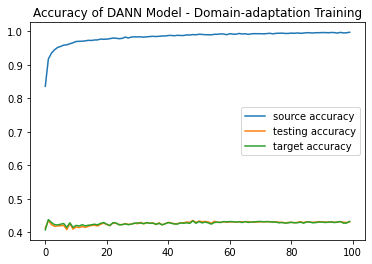

In [28]:
reset_list()

EPOCH=100
model = DANN_vgg()
gamma = 5
learning_rate = 1e-6
model_optimizer = tf.optimizers.SGD(learning_rate=lr_schedule)
train('source', EPOCH)

#Plot Results
x_axis = [i for i in range(0, EPOCH)]

plt.title("Accuracy of DANN Model - Domain-adaptation Training")
plt.plot(x_axis, source_acc, label="source accuracy")
plt.plot(x_axis, test_acc, label="testing accuracy")
plt.plot(x_axis, test2_acc, label="target accuracy")
plt.legend()

In [29]:
import pandas as pd

train_data = pd.DataFrame(
    {"source accuracy": source_acc,
     "testing accuracy": test_acc,
     "target accuracy": test2_acc
    })
train_data.to_csv("./Model/DANN_Model/DANN_128/DANN_source_VGG_128_SGD_1e-6_g5.csv")